In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1) #input -? OUtput? RF
        self.bn1=nn.BatchNorm2d(64)
        self.tns1 = nn.Conv2d(in_channels=64, out_channels=16,kernel_size=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        #self.drop1=nn.Dropout(0.5)
        self.conv3 = nn.Conv2d(16, 16, 3, padding=1)
        self.conv4 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2=nn.BatchNorm2d(32)
        self.tns2 = nn.Conv2d(in_channels=32, out_channels=16,kernel_size=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(16, 16, 3, padding=1)
        self.conv6 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn3=nn.BatchNorm2d(32)
        self.conv7=nn.Conv2d(32, 10, 3, padding=1)
        self.gpool = nn.AvgPool2d(kernel_size=7)
        #self.drop2=nn.Dropout(0.5)
#         self.fc1=nn.Linear(128, 10)
        self.drop = nn.Dropout2d(0.25)
#         self.pool2 = nn.MaxPool2d(2, 2)
#         self.conv5 = nn.Conv2d(256, 512, 3)
#         self.conv6 = nn.Conv2d(512, 1024, 3)
#         self.conv7 = nn.Conv2d(1024, 10, 3)

    def forward(self, x):
        x =self.drop(self.pool1(self.tns1(self.bn1(F.relu(self.conv1(x))))))
        x = self.drop(self.pool2(self.tns2(self.bn2(F.relu(self.conv4(F.relu(self.conv3(x))))))))
        x = self.drop(self.bn3(F.relu(self.conv6(F.relu(self.conv5(x))))))
        x=self.conv7(x)
        x=self.gpool(x)
        x=x.view(-1,10)
        #x=self.conv4(x)
        #x = F.relu(self.conv6(F.relu(self.conv5(x))))
        #x = F.relu(self.conv7(x))
        #print('x_shape:',x.shape)
#         x = x.view(-1, 128)
#         x=self.fc1(x)
        return F.log_softmax(x)

In [4]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
#device = torch.device("mps")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
       BatchNorm2d-2           [-1, 64, 28, 28]             128
            Conv2d-3           [-1, 16, 30, 30]           1,040
         MaxPool2d-4           [-1, 16, 15, 15]               0
         Dropout2d-5           [-1, 16, 15, 15]               0
            Conv2d-6           [-1, 16, 15, 15]           2,320
            Conv2d-7           [-1, 32, 15, 15]           4,640
       BatchNorm2d-8           [-1, 32, 15, 15]              64
            Conv2d-9           [-1, 16, 17, 17]             528
        MaxPool2d-10             [-1, 16, 8, 8]               0
        Dropout2d-11             [-1, 16, 8, 8]               0
           Conv2d-12             [-1, 16, 8, 8]         

/var/folders/ff/hqsbywlj7pqfrwcx68lbt1680000gp/T/ipykernel_79517/1426748816.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [6]:


torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [7]:
from tqdm import tqdm
def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        correct += GetCorrectPredCount(output, target)
        processed += len(data)
        train_loss+=loss.item()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
    train_accuracy=100*correct/processed
    train_loss=train_loss/len(train_loader)
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))
    return train_loss,train_accuracy


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy=100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss,test_accuracy

In [ ]:
device = torch.device("mps")
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
train_losses = []
test_losses = []
train_acc = []
test_acc = []
for epoch in range(1, 21):
    train_loss,train_accuracy=train(model, device, train_loader, optimizer, epoch)
    test_loss,test_accuracy=test(model, device, test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_acc.append(train_accuracy)
    test_acc.append(test_accuracy)

  0%|                                                   | 0/469 [00:00<?, ?it/s]/var/folders/ff/hqsbywlj7pqfrwcx68lbt1680000gp/T/ipykernel_79517/1426748816.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
loss=0.1790793389081955 batch_id=468: 100%|███| 469/469 [00:13<00:00, 35.72it/s]



Train set: Average loss: 0.5564, Accuracy: 49638/60000 (83%)


Test set: Average loss: 0.0971, Accuracy: 9705/10000 (97%)



loss=0.19175517559051514 batch_id=468: 100%|██| 469/469 [00:12<00:00, 36.15it/s]



Train set: Average loss: 0.1445, Accuracy: 57500/60000 (96%)


Test set: Average loss: 0.0580, Accuracy: 9816/10000 (98%)



loss=0.0778145045042038 batch_id=468: 100%|███| 469/469 [00:13<00:00, 35.32it/s]



Train set: Average loss: 0.1051, Accuracy: 58195/60000 (97%)


Test set: Average loss: 0.0497, Accuracy: 9839/10000 (98%)



loss=0.0448843352496624 batch_id=468: 100%|███| 469/469 [00:13<00:00, 35.51it/s]



Train set: Average loss: 0.0844, Accuracy: 58550/60000 (98%)


Test set: Average loss: 0.0342, Accuracy: 9888/10000 (99%)



loss=0.10073532909154892 batch_id=468: 100%|██| 469/469 [00:12<00:00, 36.08it/s]



Train set: Average loss: 0.0753, Accuracy: 58676/60000 (98%)


Test set: Average loss: 0.0527, Accuracy: 9845/10000 (98%)



loss=0.04546760395169258 batch_id=468: 100%|██| 469/469 [00:13<00:00, 36.03it/s]



Train set: Average loss: 0.0681, Accuracy: 58823/60000 (98%)


Test set: Average loss: 0.0342, Accuracy: 9881/10000 (99%)



loss=0.09883096069097519 batch_id=468: 100%|██| 469/469 [00:13<00:00, 35.34it/s]



Train set: Average loss: 0.0604, Accuracy: 58936/60000 (98%)


Test set: Average loss: 0.0308, Accuracy: 9901/10000 (99%)



loss=0.03066752292215824 batch_id=468: 100%|██| 469/469 [00:13<00:00, 34.81it/s]



Train set: Average loss: 0.0576, Accuracy: 58986/60000 (98%)


Test set: Average loss: 0.0263, Accuracy: 9921/10000 (99%)



loss=0.014952252618968487 batch_id=468: 100%|█| 469/469 [00:12<00:00, 36.13it/s]



Train set: Average loss: 0.0527, Accuracy: 59090/60000 (98%)


Test set: Average loss: 0.0246, Accuracy: 9913/10000 (99%)



loss=0.11950110644102097 batch_id=468: 100%|██| 469/469 [00:13<00:00, 35.99it/s]



Train set: Average loss: 0.0500, Accuracy: 59095/60000 (98%)


Test set: Average loss: 0.0271, Accuracy: 9913/10000 (99%)



loss=0.14977867901325226 batch_id=468: 100%|██| 469/469 [00:13<00:00, 35.86it/s]



Train set: Average loss: 0.0485, Accuracy: 59118/60000 (99%)


Test set: Average loss: 0.0275, Accuracy: 9914/10000 (99%)



loss=0.006362600717693567 batch_id=468: 100%|█| 469/469 [00:13<00:00, 36.07it/s]



Train set: Average loss: 0.0444, Accuracy: 59193/60000 (99%)


Test set: Average loss: 0.0220, Accuracy: 9924/10000 (99%)



loss=0.12408479303121567 batch_id=468: 100%|██| 469/469 [00:13<00:00, 35.58it/s]



Train set: Average loss: 0.0427, Accuracy: 59243/60000 (99%)


Test set: Average loss: 0.0249, Accuracy: 9920/10000 (99%)



loss=0.06915709376335144 batch_id=468: 100%|██| 469/469 [00:12<00:00, 36.21it/s]



Train set: Average loss: 0.0436, Accuracy: 59226/60000 (99%)


Test set: Average loss: 0.0249, Accuracy: 9920/10000 (99%)



loss=0.02205725759267807 batch_id=468: 100%|██| 469/469 [00:13<00:00, 35.91it/s]



Train set: Average loss: 0.0409, Accuracy: 59295/60000 (99%)


Test set: Average loss: 0.0269, Accuracy: 9919/10000 (99%)



loss=0.024247782304883003 batch_id=468: 100%|█| 469/469 [00:12<00:00, 36.14it/s]



Train set: Average loss: 0.0389, Accuracy: 59309/60000 (99%)


Test set: Average loss: 0.0201, Accuracy: 9931/10000 (99%)



loss=0.029221192002296448 batch_id=468: 100%|█| 469/469 [00:13<00:00, 35.96it/s]



Train set: Average loss: 0.0374, Accuracy: 59325/60000 (99%)


Test set: Average loss: 0.0216, Accuracy: 9934/10000 (99%)



loss=0.015786752104759216 batch_id=281:  60%|▌| 280/469 [00:07<00:05, 35.77it/s]

Text(0.5, 1.0, 'Test Accuracy')

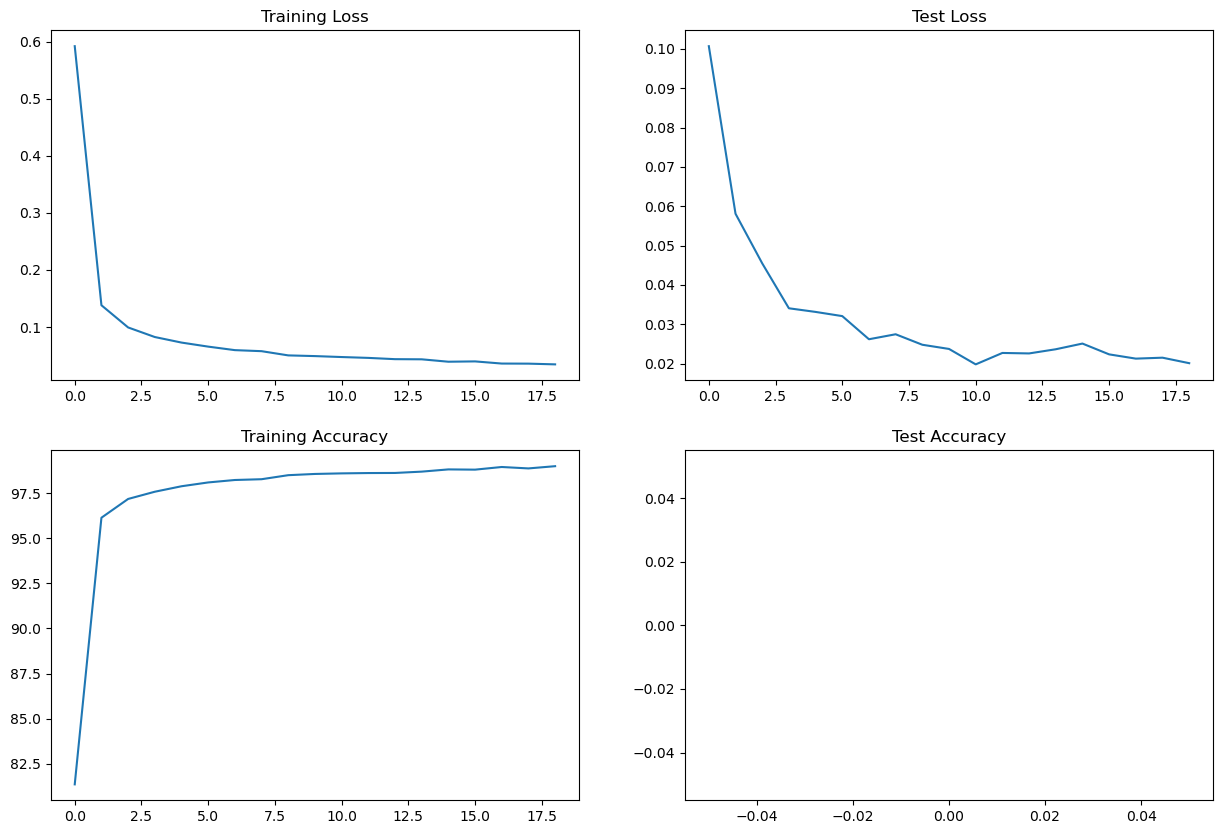

In [9]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")